<a href="https://colab.research.google.com/github/gcubillos7/technical-test-torre/blob/main/TechnicalTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Technical test

##Data importation and first approch

In [1]:
!gdown --id 1EDxy0azg2IbpL0-jRfC4bHlZTnMkrjHH

Downloading...
From: https://drive.google.com/uc?id=1EDxy0azg2IbpL0-jRfC4bHlZTnMkrjHH
To: /content/reed_uk.csv
109MB [00:00, 176MB/s] 


In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
reed=pd.read_csv('/content/reed_uk.csv')

In [4]:
reed.head(10)

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state
0,catering jobs,Chudleigh,Haulfryn Group,uk,reed,Apply now New opportunity not to be missed! H...,NaN,Commis Chef,"Permanent, full-time",3/12/2018,"£18,323 per annum",Devon
1,law jobs,Swindon,Reed,uk,reed,Apply now This role requires an experienced s...,NaN,Corporate Legal Secretary,"Permanent, full-time",3/8/2018,"£18,000 - £22,000 per annum",Wiltshire
2,factory jobs,Norfolk,Swanstaff Recruitment Ltd,uk,reed,Apply now Job Title: Warehouse personLocation...,NaN,Warehouse Person,"Permanent, full-time",2/27/2018,Salary not specified,East Anglia
3,law jobs,Hurstpierpoint,Castles Solicitors,uk,reed,Apply now Castles Solicitors are looking for ...,Required skills Admin Case Management Corresp...,Legal Secretary / Admin Assistant,"Permanent, full-time or part-time",2/21/2018,"£15,000 - £17,000 per annum, pro-rata",West Sussex
4,factory jobs,Hertfordshire,Marketplace Group,uk,reed,Apply now International Pharmaceutical Manufa...,NaN,Category Planner - Pharmaceutical,"Permanent, full-time",3/1/2018,"£37,000 - £45,000 per annum",South East England
5,retail jobs,Belfast,Vodafone,uk,reed,Apply on employer's website Retail Advisor - ...,NaN,Retail Adviser 20hrs/week - Belfast Donnegal P...,"Permanent, part-time",3/12/2018,"£9,100 - £9,152 per annum, OTE",County Antrim
6,factory jobs,Thetford,Hales Group Limited,uk,reed,"Apply now Break Press Operator - Permanent, Â...",NaN,Break Press Operator,"Permanent, full-time",2/28/2018,£9.25 - £10.15 per hour,Norfolk
7,motoring automotive jobs,Luton,Fine Recruiting Ltd,uk,reed,Apply now An exciting opportunity to start wi...,Required skills Accident Paint Repair Spray P...,Vehicle Paint Sprayer,"Permanent, full-time",3/2/2018,"£35,000 - £40,000 per annum",Bedfordshire
8,motoring automotive jobs,Blackburn,Audi,uk,reed,Apply on employer's website This exciting opp...,NaN,Vehicle Technician,"Permanent, full-time",2/28/2018,"£23,000 - £26,600 per annum",Lancashire
9,law jobs,Leeds,Rachel Clark Legal Recruitment,uk,reed,"Apply now This highly regarded, top law firm ...",Required skills Diary Management Legal Secret...,LEGAL SECRETARY,"Permanent, full-time",3/12/2018,"£18,000 - £25,000 per annum, inc benefits",West Yorkshire


In [5]:
reed.describe()

,category,city,company_name,geo,job_board,job_description,job_requirements,job_title,job_type,post_date,salary_offered,state
count,50000,50000,50000,50000,50000,50000,20548,50000,50000,50000,50000,49980
unique,37,2918,5166,1,1,42057,14887,29155,9,66,7345,167
top,health jobs,London,Hays Specialist Recruitment Limited,uk,reed,Apply on employer's website Add an annual tur...,Required skills Recruitment,Administrator,"Permanent, full-time",3/7/2018,Salary negotiable,London
freq,1930,4349,1830,50000,50000,85,123,162,36864,8472,4539,5900


geo' and 'job_board' gives no information so it will be droped.
'state' info is implicit in 'city' and 'post_date' is not necessary for the analysis

##Clean of the data


In [6]:
reed=reed.drop(['geo', 'job_board', 'state','post_date'], axis=1)

In [7]:
reed=reed.drop_duplicates()

In [8]:
reed.describe()

,category,city,company_name,job_description,job_requirements,job_title,job_type,salary_offered
count,44477,44477,44477,44477,18344,44477,44477,44477
unique,37,2918,5166,42057,14887,29155,9,7345
top,construction property jobs,London,Hays Specialist Recruitment Limited,Apply on employer's website Add an annual tur...,Required skills Recruitment,Administrator,"Permanent, full-time",Salary negotiable
freq,1829,3848,1699,83,119,144,32842,3985


We drop NaN present principaly in 'job_description'

In [9]:
reed=reed.dropna()

Then, stopwords and other characters will be removed from the text

In [10]:
def remove_stopwords(text):
      if type(text)!=float:      
        STOPWORDS = set(stopwords.words('english'))
        STOPWORDS.update(['Apply', 'now', 'Required','skills', 'per', 'annum',',','pro-rata','ote','hour','inc','benefits', '/', '1','2',
                          '3','4','5','6','7','8','9','0'])
        tokens = nltk.word_tokenize(text)
        t = ' '.join([word for word in text.split() if word not in STOPWORDS]) 
        t=t.lower()
        return t

In [11]:
for col in reed.columns:
  print(col)
  if (col!='city' and col!='category' and col!='company_name' and col!='id'):
    reed[col]=reed[col].map(lambda x: remove_stopwords(x))
  

category
city
company_name
job_description
job_requirements
job_title
job_type
salary_offered


In [12]:
reed.head(10)

,category,city,company_name,job_description,job_requirements,job_title,job_type,salary_offered
3,law jobs,Hurstpierpoint,Castles Solicitors,castles solicitors looking part full time lega...,admin case management correspondence legal sol...,legal secretary admin assistant,"permanent, full-time part-time","£15,000 - £17,000 annum,"
7,motoring automotive jobs,Luton,Fine Recruiting Ltd,an exciting opportunity start new accident rep...,accident paint repair spray paint,vehicle paint sprayer,"permanent, full-time","£35,000 - £40,000"
9,law jobs,Leeds,Rachel Clark Legal Recruitment,"this highly regarded, top law firm north engla...",diary management legal secretarial typing,legal secretary,"permanent, full-time","£18,000 - £25,000 annum,"
10,motoring automotive jobs,Bermuda Park,Keastone Recruitment,the opportunity this remarkable opportunity jo...,car dealership sales sales executive sales team,sales executive (automotive main dealer),"permanent, full-time","£12,000 - £40,000 annum, ote"
15,catering jobs,Wooburn Green,Leisure People Recruitment,"our client looking recruit committed, enthusia...",chef line chef commis chef cook kitchen staff ...,line chef part time - large private members club,"permanent, part-time",£8.00 - £8.50
16,retail jobs,Edinburgh,Switch Consulting Recruitment Limited,my client my client helping change way world w...,businesses,centre manager edinburgh,"permanent, full-time","£25,000 - £30,000 annum, ote"
17,catering jobs,Cardiff,Berry Recruitment,berry recruitment looking event staff work upc...,catering event hospitality jobs customer waite...,event staff,"temporary, part-time",£7.50
21,law jobs,Leicester,Sacco Mann,are residential conveyancing fee earner extens...,residential conveyancing paralegal filex legal...,conveyancing sales technical specialist,"permanent, full-time","£20,000 - £26,000"
22,motoring automotive jobs,Warrington,Perfect Placement Uk Ltd,"automotive, motor trade job: vehicle service a...",automotive customer services sales aftersales ...,vehicle service advisor,"permanent, full-time","£20,000 - £25,000 annum, benefits, ote"
24,retail jobs,Cirencester,4Leisure Recruitment,we seeking proactive membership sales consulta...,leisure sales,membership sales consultant - leading leisure ...,"temporary, full-time part-time",£8.00 - £10.00


In [13]:
reed.describe()

,category,city,company_name,job_description,job_requirements,job_title,job_type,salary_offered
count,18344,18344,18344,18344,18344,18344,18344,18344
unique,37,1950,3458,17501,14812,12993,9,4205
top,engineering jobs,London,Hays Specialist Recruitment Limited,customer service ticket verification rates pay...,recruitment,customer service advisor,"permanent, full-time",competitive salary
freq,940,1432,374,37,122,67,14053,1331


##Graph database creation with neo4j

In [14]:
!pip install neo4j
 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from neo4j import GraphDatabase

In [15]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [16]:
def get_job_title(line): 
    return list(line.split(" "))
 
 
def get_category_list(line):
    # Cleans category dataframe column, creating a list of categories in the
    # row.
    line=line.split(" ")
    line=line[:-1]
    return list(line)
 
def get_city_list(line):
  listline=[]
  listline.append(line)
  return listline
 
def add_job_title(job_title):
    query = '''UNWIND $rows AS row
    MERGE (jt:Job_title {job_title: row.job_title})
    RETURN count(*) as total
    '''
    return conn.query(query, parameters={'rows': job_title.to_dict('records')})
 
 
def add_city(rows):
    query = '''UNWIND $rows AS row
               MERGE (ct:City {city: row.city})
               RETURN count(*) as total
    '''
    return conn.query(query, parameters={'rows': city.to_dict('records')})
 
 
def add_category(rows): 
    query = '''
    UNWIND $rows as row
    MERGE (c:Category {category: row.category}) ON CREATE SET c.category = row.category
    
    // connect job_title
    WITH row, c
    UNWIND row.job_title_list AS job_title_list
    MATCH (jt:Job_title {job_title: job_title_list})
    MERGE (c)-[r:POSITION]->(jt)

    // connect city
    WITH  row, c 
    UNWIND row.city_list AS city_list
    MATCH (ct:City {city: city_list})
    MERGE (c)-[r:REQUIRED_IN]->(ct)
    RETURN count (c) as total
    '''
 
    return conn.query(query, parameters={'rows': reed.to_dict('records')})
 

In [17]:
reed['category_list'] = reed['category'].map(get_category_list)
category = pd.DataFrame(reed[['category_list']])
category.rename(columns={'category_list':'category'}, inplace=True)
 
 
reed['job_title_list'] = reed['job_title'].map(get_job_title)
job_title = pd.DataFrame(reed[['job_title_list']])
job_title.rename(columns={'job_title_list':'job_title'}, inplace=True)
 
 
reed['city_list'] = reed['city'].map(get_city_list)
city = pd.DataFrame(reed[['city_list']])
city.rename(columns={'city_list':'city'}, inplace=True)
 

job_title = job_title.explode('job_title').drop_duplicates(subset=['job_title'])
city = city.explode('city').drop_duplicates(subset=['city'])

Data will be upload

In [18]:
conn = Neo4jConnection(uri="bolt://34.201.30.63:7687", user="neo4j", pwd="workbooks-quantities-burns")

In [19]:
conn.query('CREATE CONSTRAINT category IF NOT EXISTS ON (c:Category) ASSERT c.category IS UNIQUE')
conn.query('CREATE CONSTRAINT city IF NOT EXISTS ON (ct:City) ASSERT ct.city IS UNIQUE')
conn.query('CREATE CONSTRAINT job_title IF NOT EXISTS ON (jt:Job_title) ASSERT jt.job_title IS UNIQUE')

[]

In [20]:
add_job_title(job_title)

[<Record total=7542>]

In [21]:
add_city(city)

[<Record total=1950>]

In [22]:
add_category(reed) #may require try multiple times
add_category(reed)

[<Record total=76689>]

Example of query

In [23]:
query_string = '''
MATCH p=()-[r:REQUIRED_IN]->(), z=()-[:POSITION]->() RETURN p,z LIMIT 25
'''

command=conn.query(query_string)
print(command[0]['p'])
print(command[0]['z'])

<Path start=<Node id=9506 labels=frozenset({'Category'}) properties={'category': 'law jobs'}> end=<Node id=7542 labels=frozenset({'City'}) properties={'city': 'Hurstpierpoint'}> size=1>
<Path start=<Node id=9506 labels=frozenset({'Category'}) properties={'category': 'law jobs'}> end=<Node id=804 labels=frozenset({'Job_title'}) properties={'job_title': 'reporting'}> size=1>


In [24]:
conn.close()

In [25]:
!gdown --id 1IyYVGWTxzE6uIZWyHinAInHdERVeK9h1

Downloading...
From: https://drive.google.com/uc?id=1IyYVGWTxzE6uIZWyHinAInHdERVeK9h1
To: /content/graph.svg
100% 27.1k/27.1k [00:00<00:00, 45.0MB/s]


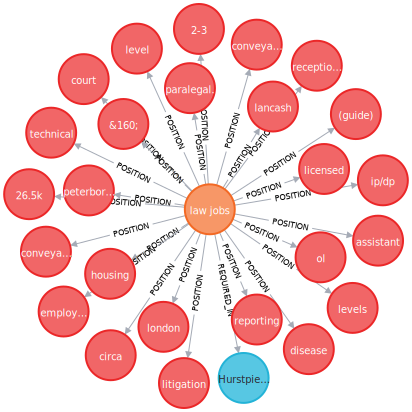

In [26]:
from IPython.display import SVG, display
display(SVG('/content/graph.svg'))

With this relationship we can analyze the category of the jobs required in some cities and the titles used in the offers

##ML problem

Try to get the category of the job based in the salary offered

First, the data of salary will be clean, then differents models will be train

In [27]:
import re
def getNumbers(str):
    array = re.findall(r'[0-9]+', str)
    return array

In [28]:
reedSalary = reed.copy()

In [29]:
for index,i in reedSalary.iterrows():
  salary=reedSalary['salary_offered'][index]
  num=getNumbers(salary)
  if len(num)==4:
    if len(num[0])==1:
      reedSalary['salary_offered'][index]=float(num[0])
    else:
      min=float(num[0]+num[1])
      max=float(num[2]+num[3])
      reedSalary['salary_offered'][index]=(max+min)/2
  elif len(num)==2:
    if len(num[0])==1:
      reedSalary['salary_offered'][index]=float(num[0])
    else:
      min=float(num[0]+num[1])
    
      reedSalary['salary_offered'][index]=min

In [30]:
reedSalary

,category,city,company_name,job_description,job_requirements,job_title,job_type,salary_offered,category_list,job_title_list,city_list
3,law jobs,Hurstpierpoint,Castles Solicitors,castles solicitors looking part full time lega...,admin case management correspondence legal sol...,legal secretary admin assistant,"permanent, full-time part-time",16000,[law],"[legal, secretary, admin, assistant]",[Hurstpierpoint]
7,motoring automotive jobs,Luton,Fine Recruiting Ltd,an exciting opportunity start new accident rep...,accident paint repair spray paint,vehicle paint sprayer,"permanent, full-time",37500,"[motoring, automotive]","[vehicle, paint, sprayer]",[Luton]
9,law jobs,Leeds,Rachel Clark Legal Recruitment,"this highly regarded, top law firm north engla...",diary management legal secretarial typing,legal secretary,"permanent, full-time",21500,[law],"[legal, secretary]",[Leeds]
10,motoring automotive jobs,Bermuda Park,Keastone Recruitment,the opportunity this remarkable opportunity jo...,car dealership sales sales executive sales team,sales executive (automotive main dealer),"permanent, full-time",26000,"[motoring, automotive]","[sales, executive, (automotive, main, dealer)]",[Bermuda Park]
15,catering jobs,Wooburn Green,Leisure People Recruitment,"our client looking recruit committed, enthusia...",chef line chef commis chef cook kitchen staff ...,line chef part time - large private members club,"permanent, part-time",8,[catering],"[line, chef, part, time, -, large, private, me...",[Wooburn Green]
...,...,...,...,...,...,...,...,...,...,...,...
49975,strategy consultancy jobs,Heathrow,Willis Global Ltd,position: global loss prevention analyst repor...,data analysis internal audit loss prevention r...,"global loss prevention analyst - retail, londo...","permanent, full-time",30000,"[strategy, consultancy]","[global, loss, prevention, analyst, -, retail,...",[Heathrow]
49978,graduate training internships jobs,Central London,Celsius Graduate Recruitment Limited,graduate business development executiveâ£23k-â...,business development sales software technology...,graduate business development executive - london,"permanent, full-time",23500,"[graduate, training, internships]","[graduate, business, development, executive, -...",[Central London]
49987,purchasing jobs,London,Elite,we partnered really unique fashion business cu...,logistics driving licence operations,logistics operations assistant,"permanent, full-time",salary negotiable,[purchasing],"[logistics, operations, assistant]",[London]
49992,purchasing jobs,Northampton,St Andrew's Healthcare,"employer's website salary: â£31,592 - â£44,430...",buying procurement strategic sourcing cips,strategic sourcing buyer,"permanent, full-time",38011,[purchasing],"[strategic, sourcing, buyer]",[Northampton]


Not numerical salary will be removed

In [31]:
reedSalary2 = reedSalary[pd.to_numeric(reedSalary['salary_offered'], errors='coerce').notnull()]
reedSalary2['salary_offered']=reedSalary2['salary_offered'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
reedSalary2

,category,city,company_name,job_description,job_requirements,job_title,job_type,salary_offered,category_list,job_title_list,city_list
3,law jobs,Hurstpierpoint,Castles Solicitors,castles solicitors looking part full time lega...,admin case management correspondence legal sol...,legal secretary admin assistant,"permanent, full-time part-time",16000,[law],"[legal, secretary, admin, assistant]",[Hurstpierpoint]
7,motoring automotive jobs,Luton,Fine Recruiting Ltd,an exciting opportunity start new accident rep...,accident paint repair spray paint,vehicle paint sprayer,"permanent, full-time",37500,"[motoring, automotive]","[vehicle, paint, sprayer]",[Luton]
9,law jobs,Leeds,Rachel Clark Legal Recruitment,"this highly regarded, top law firm north engla...",diary management legal secretarial typing,legal secretary,"permanent, full-time",21500,[law],"[legal, secretary]",[Leeds]
10,motoring automotive jobs,Bermuda Park,Keastone Recruitment,the opportunity this remarkable opportunity jo...,car dealership sales sales executive sales team,sales executive (automotive main dealer),"permanent, full-time",26000,"[motoring, automotive]","[sales, executive, (automotive, main, dealer)]",[Bermuda Park]
15,catering jobs,Wooburn Green,Leisure People Recruitment,"our client looking recruit committed, enthusia...",chef line chef commis chef cook kitchen staff ...,line chef part time - large private members club,"permanent, part-time",8,[catering],"[line, chef, part, time, -, large, private, me...",[Wooburn Green]
...,...,...,...,...,...,...,...,...,...,...,...
49970,strategy consultancy jobs,Charlestown,Equals One,service operations manager the spot salary pos...,call centre contact centre housing management ...,service operations manager,"permanent, full-time",43609,"[strategy, consultancy]","[service, operations, manager]",[Charlestown]
49975,strategy consultancy jobs,Heathrow,Willis Global Ltd,position: global loss prevention analyst repor...,data analysis internal audit loss prevention r...,"global loss prevention analyst - retail, londo...","permanent, full-time",30000,"[strategy, consultancy]","[global, loss, prevention, analyst, -, retail,...",[Heathrow]
49978,graduate training internships jobs,Central London,Celsius Graduate Recruitment Limited,graduate business development executiveâ£23k-â...,business development sales software technology...,graduate business development executive - london,"permanent, full-time",23500,"[graduate, training, internships]","[graduate, business, development, executive, -...",[Central London]
49992,purchasing jobs,Northampton,St Andrew's Healthcare,"employer's website salary: â£31,592 - â£44,430...",buying procurement strategic sourcing cips,strategic sourcing buyer,"permanent, full-time",38011,[purchasing],"[strategic, sourcing, buyer]",[Northampton]


In [33]:
reedML=reedSalary2.drop(['job_description','job_requirements','job_type','company_name','city','category_list','job_title_list','city_list','job_title'],axis=1)
from sklearn.model_selection import train_test_split
X=reedML.drop(['category'], axis=1)
y=reedML['category']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30)

Models trained: Decision Tree, K-Neighbors and Naive Bayes.

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
DTC=DecisionTreeClassifier()
DTC.fit(X_train,y_train)
y_pred=DTC.predict(X_test)
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1 score', f1_score(y_test,y_pred,average='weighted'))
print('Recall', recall_score(y_test,y_pred,average='weighted'))
print('Precision', precision_score(y_test,y_pred,average='weighted'))

Accuracy 0.1621043627031651
F1 score 0.1391689539446899
Recall 0.1621043627031651
Precision 0.18101594813133698


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn.neighbors import KNeighborsClassifier
KN=KNeighborsClassifier()
KN.fit(X_train,y_train)
y_pred=KN.predict(X_test)
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1 score', f1_score(y_test,y_pred,average='weighted'))
print('Recall', recall_score(y_test,y_pred,average='weighted'))
print('Precision', precision_score(y_test,y_pred,average='weighted'))

Accuracy 0.11869118905047049
F1 score 0.10986480874280813
Recall 0.11869118905047049
Precision 0.1432680087433744


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.naive_bayes import GaussianNB
NB=GaussianNB()
NB.fit(X_train,y_train)
y_pred=NB.predict(X_test)
print('Accuracy', accuracy_score(y_test,y_pred))
print('F1 score', f1_score(y_test,y_pred,average='weighted'))
print('Recall', recall_score(y_test,y_pred,average='weighted'))
print('Precision', precision_score(y_test,y_pred,average='weighted'))

Accuracy 0.08212147134302823
F1 score 0.041213617709541996
Recall 0.08212147134302823
Precision 0.039621276957590906


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the results obtained, is clearly that the result wasn't the expected, this can be for the type of the salary, it can be better, for another approach, group the salary in intervals.

Also the data is not to very related between columns so predict something is very hard and the type of the data don't help.